In [1]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import time

In [2]:
device = ("cuda" if torch.cuda.is_available()
         else "mps" if torch.mps.is_available()
         else "cpu")
device


'mps'

# Load Data

In [3]:
image_transfroms = transforms.Compose([
    # data Augumentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std = [0.229,0.224, 0.225 ]) #these are the mean , std for imageNet data 
    # Since we are using Transfer Learning from Resnet or other Efficient net as those nets are train on imageNet
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform = image_transfroms )
len(dataset)

2300

In [5]:
class_names= dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75* len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [9]:
# DataLoader 

train_loader =  DataLoader(train_dataset, batch_size= 32, shuffle= True)
val_loader =  DataLoader(val_dataset, batch_size= 32, shuffle= True)

In [10]:
# Checking the size
for images , labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[0].shape

torch.Size([3, 224, 224])

In [12]:
images[0].permute(1,2, 0 ).shape

torch.Size([224, 224, 3])

In [13]:
labels[0]

tensor(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4831376].


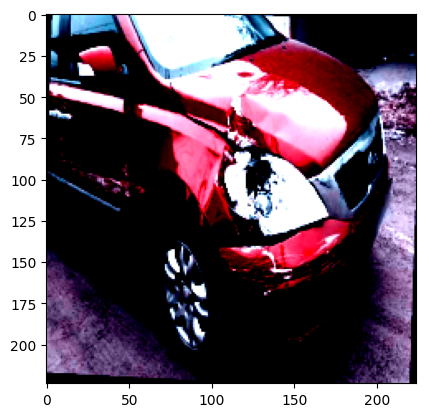

In [14]:
plt.imshow(images[0].permute(1,2, 0 )) # expects [224 , 224 , 3] not in [3, 244, 244]
plt.show()

# Model 1

In [16]:
# car classifier 
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3 , stride=1 , padding=1 ), # (16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (16, 122, 122)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3 , stride=1 , padding=1 ), # (32, 122, 122)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3 , stride=1 , padding=1 ), # (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (64, 28, 28)

            nn.Flatten(),

            # FCN 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            
            
            
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [17]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [51]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10 )

Batch: 10, Epoch: 1, Loss: 1.75
Batch: 20, Epoch: 1, Loss: 1.55
Batch: 30, Epoch: 1, Loss: 1.29
Batch: 40, Epoch: 1, Loss: 1.37
Batch: 50, Epoch: 1, Loss: 1.14
Epoch [1/10], Avg Loss: 1.5819
*** Validation Accuracy: 53.91% ***
Batch: 10, Epoch: 2, Loss: 0.89
Batch: 20, Epoch: 2, Loss: 0.98
Batch: 30, Epoch: 2, Loss: 1.34
Batch: 40, Epoch: 2, Loss: 0.92
Batch: 50, Epoch: 2, Loss: 0.97
Epoch [2/10], Avg Loss: 1.0747
*** Validation Accuracy: 46.43% ***
Batch: 10, Epoch: 3, Loss: 0.80
Batch: 20, Epoch: 3, Loss: 1.20
Batch: 30, Epoch: 3, Loss: 0.92
Batch: 40, Epoch: 3, Loss: 1.06
Batch: 50, Epoch: 3, Loss: 1.41
Epoch [3/10], Avg Loss: 0.9681
*** Validation Accuracy: 54.26% ***
Batch: 10, Epoch: 4, Loss: 0.79
Batch: 20, Epoch: 4, Loss: 0.87
Batch: 30, Epoch: 4, Loss: 0.94
Batch: 40, Epoch: 4, Loss: 0.82
Batch: 50, Epoch: 4, Loss: 0.85
Epoch [4/10], Avg Loss: 0.9093
*** Validation Accuracy: 59.13% ***
Batch: 10, Epoch: 5, Loss: 0.78
Batch: 20, Epoch: 5, Loss: 0.93
Batch: 30, Epoch: 5, Loss: 0

###  Model 2 CNN with Regularization

In [54]:
# car classifier 
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3 , stride=1 , padding=1 ), # (16, 244, 244)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (16, 122, 122)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3 , stride=1 , padding=1 ), # (32, 122, 122)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3 , stride=1 , padding=1 ), # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (64, 28, 28)

            nn.Flatten(),

            # FCN 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
            
            
            
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [55]:
model = CarClassifierCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 20.73
Batch: 20, Epoch: 1, Loss: 8.34
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.56
Batch: 50, Epoch: 1, Loss: 1.56
Epoch [1/5], Avg Loss: 9.0566
*** Validation Accuracy: 37.91% ***
Batch: 10, Epoch: 2, Loss: 2.01
Batch: 20, Epoch: 2, Loss: 1.33
Batch: 30, Epoch: 2, Loss: 1.45
Batch: 40, Epoch: 2, Loss: 1.37
Batch: 50, Epoch: 2, Loss: 1.48
Epoch [2/5], Avg Loss: 1.4110
*** Validation Accuracy: 43.83% ***
Batch: 10, Epoch: 3, Loss: 1.20
Batch: 20, Epoch: 3, Loss: 1.31
Batch: 30, Epoch: 3, Loss: 1.36
Batch: 40, Epoch: 3, Loss: 1.15
Batch: 50, Epoch: 3, Loss: 1.07
Epoch [3/5], Avg Loss: 1.2802
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 4, Loss: 1.20
Batch: 20, Epoch: 4, Loss: 1.49
Batch: 30, Epoch: 4, Loss: 1.12
Batch: 40, Epoch: 4, Loss: 1.01
Batch: 50, Epoch: 4, Loss: 1.30
Epoch [4/5], Avg Loss: 1.2418
*** Validation Accuracy: 52.35% ***
Batch: 10, Epoch: 5, Loss: 1.40
Batch: 20, Epoch: 5, Loss: 1.30
Batch: 30, Epoch: 5, Loss: 0.88

### Model 3: Transfer Learning with EfficientNet

In [56]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/dineshraju/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 25.0MB/s]


1280

In [18]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [19]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.69
Batch: 20, Epoch: 1, Loss: 1.44
Batch: 30, Epoch: 1, Loss: 1.39
Batch: 40, Epoch: 1, Loss: 1.42
Batch: 50, Epoch: 1, Loss: 1.21
Epoch [1/10], Avg Loss: 1.4771
*** Validation Accuracy: 57.91% ***
Batch: 10, Epoch: 2, Loss: 1.16
Batch: 20, Epoch: 2, Loss: 1.32
Batch: 30, Epoch: 2, Loss: 1.23
Batch: 40, Epoch: 2, Loss: 1.09
Batch: 50, Epoch: 2, Loss: 1.14
Epoch [2/10], Avg Loss: 1.1399
*** Validation Accuracy: 60.70% ***
Batch: 10, Epoch: 3, Loss: 1.03
Batch: 20, Epoch: 3, Loss: 1.05
Batch: 30, Epoch: 3, Loss: 0.93
Batch: 40, Epoch: 3, Loss: 0.98
Batch: 50, Epoch: 3, Loss: 1.12
Epoch [3/10], Avg Loss: 1.0170
*** Validation Accuracy: 63.48% ***
Batch: 10, Epoch: 4, Loss: 1.03
Batch: 20, Epoch: 4, Loss: 0.73
Batch: 30, Epoch: 4, Loss: 1.07
Batch: 40, Epoch: 4, Loss: 0.89
Batch: 50, Epoch: 4, Loss: 0.98
Epoch [4/10], Avg Loss: 0.9547
*** Validation Accuracy: 64.70% ***
Batch: 10, Epoch: 5, Loss: 1.05
Batch: 20, Epoch: 5, Loss: 0.78
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [20]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.90
Batch: 20, Epoch: 1, Loss: 0.87
Batch: 30, Epoch: 1, Loss: 0.43
Batch: 40, Epoch: 1, Loss: 0.64
Batch: 50, Epoch: 1, Loss: 0.90
Epoch [1/10], Avg Loss: 0.9258
*** Validation Accuracy: 71.13% ***
Batch: 10, Epoch: 2, Loss: 0.77
Batch: 20, Epoch: 2, Loss: 0.64
Batch: 30, Epoch: 2, Loss: 0.35
Batch: 40, Epoch: 2, Loss: 0.56
Batch: 50, Epoch: 2, Loss: 0.37
Epoch [2/10], Avg Loss: 0.4838
*** Validation Accuracy: 74.43% ***
Batch: 10, Epoch: 3, Loss: 0.17
Batch: 20, Epoch: 3, Loss: 0.60
Batch: 30, Epoch: 3, Loss: 0.40
Batch: 40, Epoch: 3, Loss: 0.16
Batch: 50, Epoch: 3, Loss: 0.25
Epoch [3/10], Avg Loss: 0.3332
*** Validation Accuracy: 72.52% ***
Batch: 10, Epoch: 4, Loss: 0.32
Batch: 20, Epoch: 4, Loss: 0.13
Batch: 30, Epoch: 4, Loss: 0.23
Batch: 40, Epoch: 4, Loss: 0.43
Batch: 50, Epoch: 4, Loss: 0.26
Epoch [4/10], Avg Loss: 0.2448
*** Validation Accuracy: 79.48% ***
Batch: 10, Epoch: 5, Loss: 0.13
Batch: 20, Epoch: 5, Loss: 0.22
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [62]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.30
Batch: 20, Epoch: 1, Loss: 0.78
Batch: 30, Epoch: 1, Loss: 0.55
Batch: 40, Epoch: 1, Loss: 0.39
Batch: 50, Epoch: 1, Loss: 0.68
Epoch [1/10], Avg Loss: 0.8939
*** Validation Accuracy: 58.09% ***
Batch: 10, Epoch: 2, Loss: 0.46
Batch: 20, Epoch: 2, Loss: 0.38
Batch: 30, Epoch: 2, Loss: 0.40
Batch: 40, Epoch: 2, Loss: 0.66
Batch: 50, Epoch: 2, Loss: 0.33
Epoch [2/10], Avg Loss: 0.4987
*** Validation Accuracy: 78.43% ***
Batch: 10, Epoch: 3, Loss: 0.32
Batch: 20, Epoch: 3, Loss: 0.38
Batch: 30, Epoch: 3, Loss: 0.21
Batch: 40, Epoch: 3, Loss: 0.39
Batch: 50, Epoch: 3, Loss: 0.43
Epoch [3/10], Avg Loss: 0.3427
*** Validation Accuracy: 79.65% ***
Batch: 10, Epoch: 4, Loss: 0.18
Batch: 20, Epoch: 4, Loss: 0.30
Batch: 30, Epoch: 4, Loss: 0.22
Batch: 40, Epoch: 4, Loss: 0.34
Batch: 50, Epoch: 4, Loss: 0.37
Epoch [4/10], Avg Loss: 0.2931
*** Validation Accuracy: 62.96% ***
Batch: 10, Epoch: 5, Loss: 0.13
Batch: 20, Epoch: 5, Loss: 0.13
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [63]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       145
           1       0.78      0.69      0.73        87
           2       0.90      0.92      0.91       118
           3       0.91      0.65      0.76        82
           4       0.58      0.60      0.59        70
           5       0.65      0.86      0.74        73

    accuracy                           0.79       575
   macro avg       0.78      0.77      0.77       575
weighted avg       0.81      0.79      0.79       575



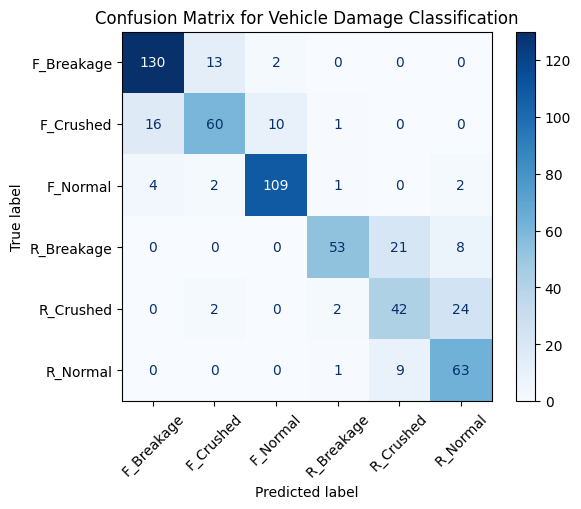

In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [67]:
torch.save(model.state_dict(), 'saved_model.pth')